Reading file /media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch/epoch3d/Cpf-Work/cone/cone1-a=145-2微米/density0014.sdf
t() = time
x(2501, 351, 351) = grid
y(2501, 351, 351) = grid
z(2501, 351, 351) = grid
xc(2500, 350, 350) = grid_mid
yc(2500, 350, 350) = grid_mid
zc(2500, 350, 350) = grid_mid
Reading file /media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch/epoch3d/Cpf-Work/cone/cone1-a=145-2微米/field0014.sdf
t() = time
bx(2500, 350, 350) = bx
by(2500, 350, 350) = by
bz(2500, 350, 350) = bz
ex(2500, 350, 350) = ex
ey(2500, 350, 350) = ey
ez(2500, 350, 350) = ez
x(2501, 351, 351) = grid
y(2501, 351, 351) = grid
z(2501, 351, 351) = grid
xc(2500, 350, 350) = grid_mid
yc(2500, 350, 350) = grid_mid
zc(2500, 350, 350) = grid_mid
Reading file /media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch/epoch3d/Cpf-Work/cone/cone1-a=145-2微米/density0015.sdf
t() = time
x(2501, 351, 351) = grid
y(2501, 351, 351) = grid
z(2501, 351, 351) = grid
xc(2500, 350, 350) = grid_mid
yc(2500, 350, 350) = grid_m

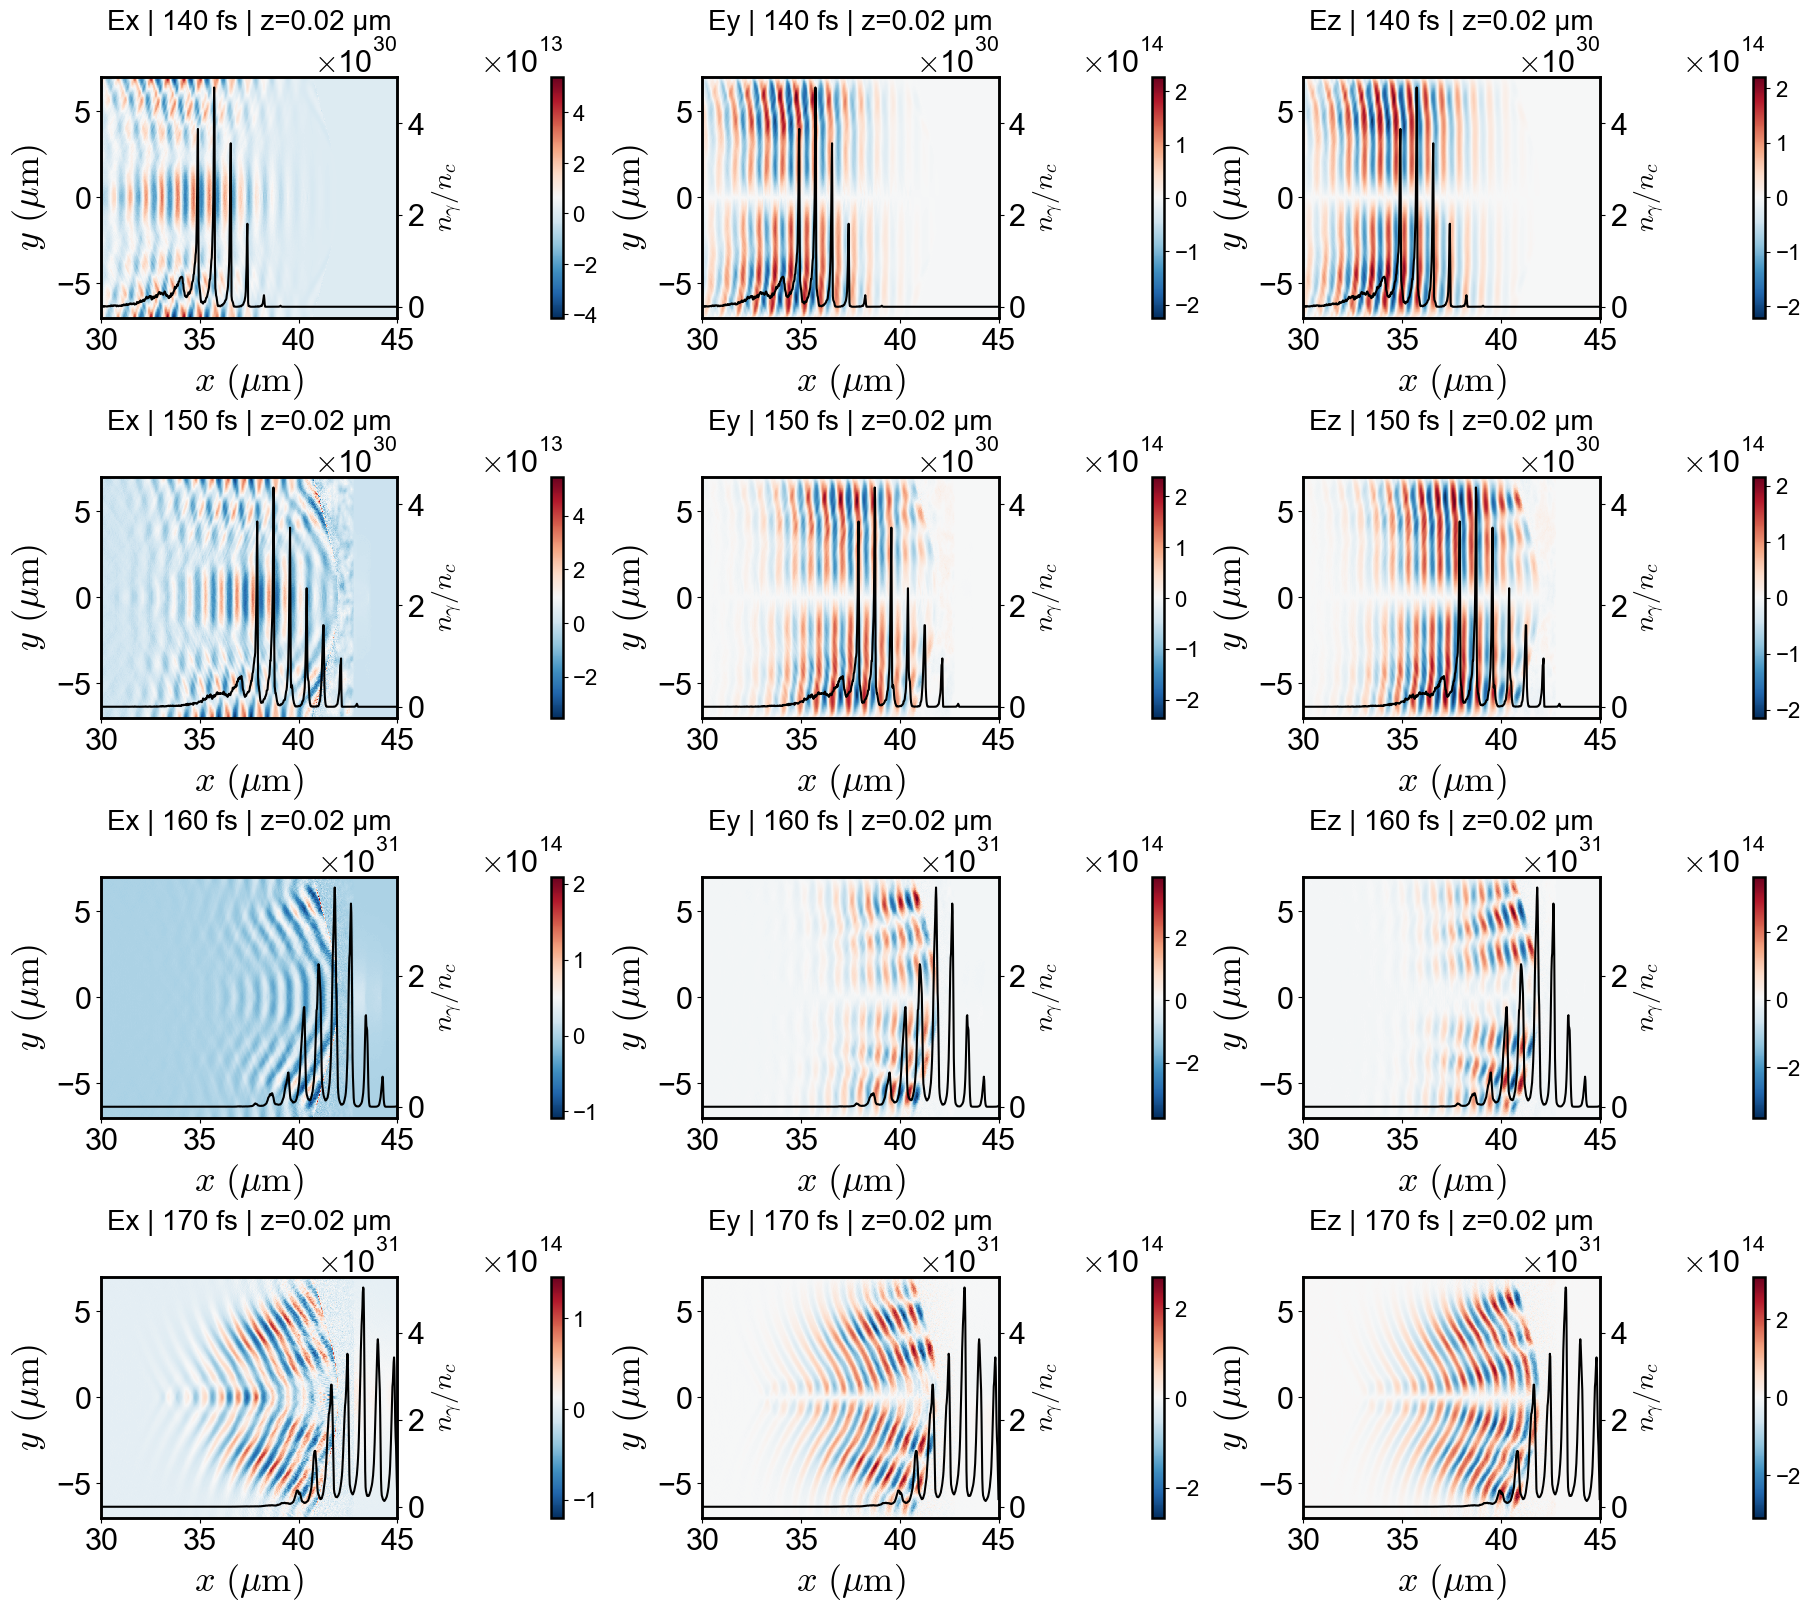

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sdf_helper as sh
from matplotlib.ticker import ScalarFormatter

def set_plot_style():
    mpl.rcParams.update({
        'font.family': 'Arial',
        'font.size': 22,            # 整体默认字体更大
        'axes.labelsize': 26,       # 坐标轴标签字体更大
        'axes.titlesize': 20,       # 标题字体更大
        'axes.linewidth': 1.8,
        'lines.linewidth': 2.5,
        'xtick.labelsize': 22,      # x 轴刻度字体更大
        'ytick.labelsize': 22,      # y 轴刻度字体更大
        'xtick.direction': 'out',
        'ytick.direction': 'out',
        'legend.fontsize': 18,
        'savefig.dpi': 600,
        'savefig.bbox': 'tight',
        'mathtext.fontset': 'cm',
        'mathtext.rm': 'serif',
        'axes.formatter.useoffset': False,
        'axes.formatter.use_mathtext': True,
    })

set_plot_style()

# 参数设置
base_path_density = '/media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch/epoch3d/Cpf-Work/cone/cone1-a=145-2微米'
base_path_field = '/media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch/epoch3d/Cpf-Work/cone/cone1-a=145-2微米'
file_indices = [14, 15, 16, 17]#, 18]
field_names = ['Ex', 'Ey', 'Ez']
x_range = (30, 45)  # μm 范围

fig, axes = plt.subplots(len(file_indices), len(field_names), figsize=(6 * len(field_names), 4 * len(file_indices)), constrained_layout=True)

for row_idx, file_index in enumerate(file_indices):
    ### 读取密度数据 ###
    den_file = f'density{file_index:04d}.sdf'
    den_path = os.path.join(base_path_density, den_file)
    den_crit = 0.17419597124e28

    den_data = sh.getdata(den_path)
    ne = den_data.Derived_Number_Density_Photon.data
    E = 1#den_data.Derived_Average_Particle_Energy_Photon.data
    weighted_density = ne * E  # 加权密度

    x_den = den_data.Grid_Grid_mid.data[0] / 1e-6
    y_den = den_data.Grid_Grid_mid.data[1] / 1e-6
    z_den = den_data.Grid_Grid_mid.data[2] / 1e-6

    # 选取 y,z 范围 [-100, 100] μm 内积分（与你代码中一致）
    y_min, y_max = -100, 100
    z_min, z_max = -100, 100
    y_mask = (y_den >= y_min) & (y_den <= y_max)
    z_mask = (z_den >= z_min) & (z_den <= z_max)
    y_start, y_end = np.where(y_mask)[0][[0, -1]]
    z_start, z_end = np.where(z_mask)[0][[0, -1]]
    # python切片需要+1
    y_end += 1
    z_end += 1

    # 沿y,z积分（求和）
    ne_sum_partial_yz = np.sum(weighted_density[:, y_start:y_end, z_start:z_end], axis=(1, 2))

    # 限制x范围
    x_mask_den = (x_den >= x_range[0]) & (x_den <= x_range[1])
    x_limited_den = x_den[x_mask_den]
    ne_limited = ne_sum_partial_yz[x_mask_den]

    ### 读取电场数据 ###
    field_file = f'field{file_index:04d}.sdf'
    field_path = os.path.join(base_path_field, field_file)
    field_data = sh.getdata(field_path)

    Ex = field_data.Electric_Field_Ex.data
    Ey = field_data.Electric_Field_Ey.data
    Ez = field_data.Electric_Field_Ez.data
    fields = [Ex, Ey, Ez]

    grid = [g / 1e-6 for g in field_data.Grid_Grid_mid.data]
    x_field, y_field, z_field = grid
    z_index = len(z_field) // 2

    # 限制 x 范围，准备网格
    x_mask_field = (x_field >= x_range[0]) & (x_field <= x_range[1])
    x_limited_field = x_field[x_mask_field]
    X, Y = np.meshgrid(x_limited_field, y_field, indexing='ij')

    for col_idx, field in enumerate(fields):
        field_slice = field[x_mask_field, :, z_index]
        ax = axes[row_idx, col_idx] if len(file_indices) > 1 else axes[col_idx]

        c = ax.pcolormesh(X, Y, field_slice, shading='auto', cmap='RdBu_r', rasterized=True)

        # 色条设置科学记数法
        cb = fig.colorbar(c, ax=ax)
        cb.ax.tick_params(labelsize=16)
        cb.formatter = ScalarFormatter(useMathText=True)
        cb.formatter.set_powerlimits((0,0))
        cb.update_ticks()

        # 坐标轴标签与刻度设置
        ax.set_xlabel(r'$x\ (\mu\mathrm{m})$')
        ax.set_ylabel(r'$y\ (\mu\mathrm{m})$')
        # ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        # ax.xaxis.get_major_formatter().set_powerlimits((0,0))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.get_major_formatter().set_powerlimits((0,0))

        # 添加时间标签
        time_fs = file_index * 10  # 例如 field0014对应140 fs
        ax.set_title(f'{field_names[col_idx]} | {time_fs} fs | z={z_field[z_index]:.2f} μm')

        # 在电场图上叠加密度折线图（x轴共享，y轴是ne_limited）
        # 用次坐标轴（共享x轴），保持比例，黑色线条
        ax2 = ax.twinx()
        ax2.plot(x_limited_den, ne_limited, color='black', linewidth=1.5, label='Weighted Density')
        ax2.set_ylabel(r'$n_\gamma/n_c$', color='black', fontsize=20)
        ax2.tick_params(axis='y', colors='black')
        ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax2.yaxis.get_major_formatter().set_powerlimits((0,0))

fig.savefig(r"/media/lan/Lexar/EPOCH代码/program1——cone代码/150-170.pdf", format='pdf')

plt.show()
